<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/CA_TimeSeries_LSTM_withFeatures_byGini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

> This colab is used to apply LSTM using the features selected from colab: CA_FeatureRanking_Gini.ipynb
> The features are selected by gini score using 3 different techniques
> WE are doing it for all the CA counties together


# Mount Google Drive

In [233]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [234]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_alldatasets_Jan13.csv
 NY_CombinedData_Labeled_CDCGuideline_Jan15.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_MarylandData_Labeled_CDCGuideline_Jan15.csv
 NY_processedMarylandData_Jan11.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CombinedData_Labeled_CDCGuideline_Jan15.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_MarylandData_Labeled_CDCGuideline_Jan15.csv
 TX_processedMarylandData_Jan11.csv
 TX_processedMarylandData_Jan11.gsheet
 TX_SocialDistancingDataJan10.cs

In [235]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import median_absolute_error, mean_absolute_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


# 1.Load combined data for CA

In [236]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_alldatasets_Jan13.csv',low_memory=False)
CA_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.6840,58,6.0000,9.0000,15.0000,1.0000,4.0000,0.0000
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.1820,98,4.0000,7.0000,7.0000,-1.0000,3.0000,0.0000
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.2710,100,5.0000,12.0000,41.0000,0.0000,1.0000,-1.0000
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.2090,99,1.0000,6.0000,23.0000,-3.0000,1.0000,0.0000
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.6540,106,1.0000,6.0000,12.0000,-5.0000,-1.0000,1.0000


## Features

In [237]:
X_cols_all = [ 'mask_rule_active','m50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline','population', 'FIPS',
       'residential_percent_change_from_baseline','Date','New cases']

# from gini coeffs; only taking positive value features
X_cols_feature_gini_coef = ['mask_rule_active', 'm50', 'm50_index',
                           'parks_percent_change_from_baseline', 'residential_percent_change_from_baseline','population', 'FIPS',
                            'transit_stations_percent_change_from_baseline','Date','New cases']

# from gini extra tree classifier; taking top 6

X_cols_feature_gini_rfe = ['mask_rule_active', 'm50', 'm50_index',
                           'workplaces_percent_change_from_baseline','parks_percent_change_from_baseline','population', 'FIPS',
                          'residential_percent_change_from_baseline',
                          'Date','New cases']



In [238]:
## for LA only code-old
LA_combined_data_all = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County'][X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_gini_coef = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County'][X_cols_feature_gini_coef]
print(LA_combined_data_gini_coef.shape)
LA_combined_data_gini_coef.head(5)

LA_combined_data_gini_rfe = CA_combined_data[CA_combined_data['County Name'] == 'Los Angeles County'][X_cols_feature_gini_rfe]
print(LA_combined_data_gini_rfe.shape)
LA_combined_data_gini_rfe.head(5)

(300, 13)
(300, 10)
(300, 10)


,mask_rule_active,m50,m50_index,workplaces_percent_change_from_baseline,parks_percent_change_from_baseline,population,FIPS,residential_percent_change_from_baseline,Date,New cases
4940,0,3.9960,60,1.0000,-5.0000,10039107,6037,0.0000,2020-03-01,0
4941,0,6.5020,98,4.0000,8.0000,10039107,6037,-1.0000,2020-03-02,0
4942,0,6.5910,99,3.0000,32.0000,10039107,6037,-1.0000,2020-03-03,0
4943,0,6.5950,100,2.0000,9.0000,10039107,6037,0.0000,2020-03-04,6
4944,0,7.0080,106,2.0000,9.0000,10039107,6037,0.0000,2020-03-05,4


In [239]:
#taking all the counties

LA_combined_data_all = CA_combined_data[X_cols_all]
print(LA_combined_data_all.shape)

LA_combined_data_gini_coef = CA_combined_data[X_cols_feature_gini_coef]
print(LA_combined_data_gini_coef.shape)
LA_combined_data_gini_coef.head(5)

LA_combined_data_gini_rfe = CA_combined_data[X_cols_feature_gini_rfe]
print(LA_combined_data_gini_rfe.shape)
LA_combined_data_gini_rfe.head(5)

(15821, 13)
(15821, 10)
(15821, 10)


,mask_rule_active,m50,m50_index,workplaces_percent_change_from_baseline,parks_percent_change_from_baseline,population,FIPS,residential_percent_change_from_baseline,Date,New cases
0,0,3.6840,58,4.0000,15.0000,1671329,6001,0.0000,2020-03-01,0
1,0,6.1820,98,3.0000,7.0000,1671329,6001,0.0000,2020-03-02,0
2,0,6.2710,100,1.0000,41.0000,1671329,6001,-1.0000,2020-03-03,1
3,0,6.2090,99,1.0000,23.0000,1671329,6001,0.0000,2020-03-04,0
4,0,6.6540,106,-1.0000,12.0000,1671329,6001,1.0000,2020-03-05,0


In [240]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [241]:
LA_combined_data_all['Date'] = LA_combined_data_all['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_gini_coef['Date'] = LA_combined_data_gini_coef['Date'].apply(lambda x: datetime_to_float(x))
LA_combined_data_gini_rfe['Date'] = LA_combined_data_gini_rfe['Date'].apply(lambda x: datetime_to_float(x))

#Harris_combined_data.index.name = 'Date'
LA_combined_data_gini_coef.head()

,mask_rule_active,m50,m50_index,parks_percent_change_from_baseline,residential_percent_change_from_baseline,population,FIPS,transit_stations_percent_change_from_baseline,Date,New cases
0,0,3.6840,58,15.0000,0.0000,1671329,6001,1.0000,1583020800.0000,0
1,0,6.1820,98,7.0000,0.0000,1671329,6001,-1.0000,1583107200.0000,0
2,0,6.2710,100,41.0000,-1.0000,1671329,6001,0.0000,1583193600.0000,1
3,0,6.2090,99,23.0000,0.0000,1671329,6001,-3.0000,1583280000.0000,0
4,0,6.6540,106,12.0000,1.0000,1671329,6001,-5.0000,1583366400.0000,0


In [242]:
print(len(LA_combined_data_gini_rfe.columns))
LA_combined_data_gini_rfe.dtypes

10


mask_rule_active                              int64
m50                                         float64
m50_index                                     int64
workplaces_percent_change_from_baseline     float64
parks_percent_change_from_baseline          float64
population                                    int64
FIPS                                          int64
residential_percent_change_from_baseline    float64
Date                                        float64
New cases                                     int64
dtype: object

## Preprocessing data for LSTM

In [243]:
LA_combined_data_all_selected = LA_combined_data_all[X_cols_all]
LA_combined_data_gini_coef_selected = LA_combined_data_gini_coef[X_cols_feature_gini_coef]
LA_combined_data_gini_rfe_selected = LA_combined_data_gini_rfe[X_cols_feature_gini_rfe]

In [244]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## All values for CA training data

### Date Column Index

In [245]:
#taking the 'Date' column location

col_idx = len(X_cols_all) -1
print(col_idx)

12


In [246]:
values = LA_combined_data_all.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var11(t)  var12(t)  var13(t)
1     0.0000     0.0114     0.0041  ...    0.1591    0.0032    0.0213
2     0.0000     0.0191     0.0070  ...    0.1364    0.0065    0.0221
3     0.0000     0.0194     0.0071  ...    0.1591    0.0097    0.0213
4     0.0000     0.0192     0.0071  ...    0.1818    0.0129    0.0213
5     0.0000     0.0206     0.0075  ...    0.2045    0.0161    0.0213

[5 rows x 26 columns]


### Train Test Split

In [247]:
values.shape[0]

15821

In [248]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

8068
values shape  (10085, 26)
(8068, 1, 25) (8068,) (2017, 1, 25) (2017,)


### Training LSTM

Epoch 1/100
113/113 - 2s - loss: 0.1112 - val_loss: 0.0495
Epoch 2/100
113/113 - 0s - loss: 0.0824 - val_loss: 0.0424
Epoch 3/100
113/113 - 0s - loss: 0.0698 - val_loss: 0.0449
Epoch 4/100
113/113 - 0s - loss: 0.0637 - val_loss: 0.0493
Epoch 5/100
113/113 - 0s - loss: 0.0610 - val_loss: 0.0500
Epoch 6/100
113/113 - 0s - loss: 0.0623 - val_loss: 0.0488
Epoch 7/100
113/113 - 0s - loss: 0.0592 - val_loss: 0.0445
Epoch 8/100
113/113 - 0s - loss: 0.0632 - val_loss: 0.0425
Epoch 9/100
113/113 - 0s - loss: 0.0591 - val_loss: 0.0417
Epoch 10/100
113/113 - 0s - loss: 0.0629 - val_loss: 0.0421
Epoch 11/100
113/113 - 0s - loss: 0.0585 - val_loss: 0.0411
Epoch 12/100
113/113 - 0s - loss: 0.0616 - val_loss: 0.0408
Epoch 13/100
113/113 - 0s - loss: 0.0574 - val_loss: 0.0426
Epoch 14/100
113/113 - 0s - loss: 0.0607 - val_loss: 0.0397
Epoch 15/100
113/113 - 0s - loss: 0.0569 - val_loss: 0.0472
Epoch 16/100
113/113 - 0s - loss: 0.0597 - val_loss: 0.0413
Epoch 17/100
113/113 - 0s - loss: 0.0571 - val_lo

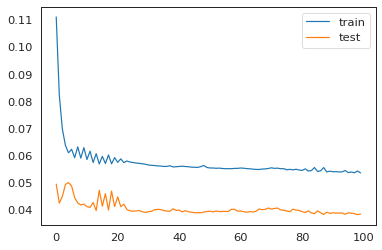

In [249]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Test

In [250]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(2017, 25)
Test MSE: 0.006
Test RMSE: 0.080
median_absolute_error 0.011253856
mean_absolute_error 0.03837361


## Data Training: For Gini-Coefficient Selected Features 

### Date Column Index

In [251]:
col_idx = len(X_cols_feature_gini_coef)-1
print(col_idx)

9


In [252]:
len(LA_combined_data_gini_coef.columns)

10

In [253]:
values = LA_combined_data_gini_coef.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t)  var9(t)  var10(t)
1     0.0000     0.0114     0.0041  ...   0.4703   0.0032    0.0213
2     0.0000     0.0191     0.0070  ...   0.4757   0.0065    0.0221
3     0.0000     0.0194     0.0071  ...   0.4595   0.0097    0.0213
4     0.0000     0.0192     0.0071  ...   0.4486   0.0129    0.0213
5     0.0000     0.0206     0.0075  ...   0.4378   0.0161    0.0213

[5 rows x 20 columns]


### Train Test split

In [254]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

8072
values shape  (10091, 20)
(8072, 1, 19) (8072,) (2019, 1, 19) (2019,)


### Training LSTM for feature selected data

In [255]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/200
113/113 - 2s - loss: 0.1057 - val_loss: 0.0523
Epoch 2/200
113/113 - 0s - loss: 0.0834 - val_loss: 0.0424
Epoch 3/200
113/113 - 0s - loss: 0.0686 - val_loss: 0.0458
Epoch 4/200
113/113 - 0s - loss: 0.0612 - val_loss: 0.0456
Epoch 5/200
113/113 - 0s - loss: 0.0593 - val_loss: 0.0469
Epoch 6/200
113/113 - 0s - loss: 0.0592 - val_loss: 0.0463
Epoch 7/200
113/113 - 0s - loss: 0.0586 - val_loss: 0.0469
Epoch 8/200
113/113 - 0s - loss: 0.0577 - val_loss: 0.0492
Epoch 9/200
113/113 - 0s - loss: 0.0584 - val_loss: 0.0469
Epoch 10/200
113/113 - 0s - loss: 0.0575 - val_loss: 0.0485
Epoch 11/200
113/113 - 0s - loss: 0.0581 - val_loss: 0.0451
Epoch 12/200
113/113 - 0s - loss: 0.0574 - val_loss: 0.0455
Epoch 13/200
113/113 - 0s - loss: 0.0574 - val_loss: 0.0443
Epoch 14/200
113/113 - 0s - loss: 0.0573 - val_loss: 0.0441
Epoch 15/200
113/113 - 0s - loss: 0.0571 - val_loss: 0.0437
Epoch 16/200
113/113 - 0s - loss: 0.0570 - val_loss: 0.0436
Epoch 17/200
113/113 - 0s - loss: 0.0569 - val_lo

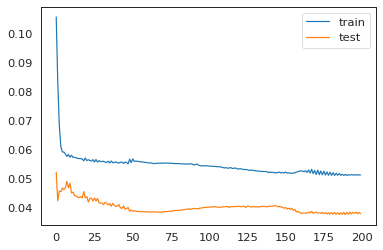

In [256]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [257]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(2019, 19)
Test MSE: 0.006
Test RMSE: 0.079
median_absolute_error 0.011820227
mean_absolute_error 0.03806342


## Data Training: For Extra Tree Classifier Selected Features 

### Date Column Index

In [258]:
col_idx = len(X_cols_feature_gini_rfe) -1 
print(col_idx)

9


In [259]:
len(LA_combined_data_gini_rfe.columns)

10

In [260]:
values = LA_combined_data_gini_rfe.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t)  var9(t)  var10(t)
1     0.0000     0.0114     0.0041  ...   0.1591   0.0032    0.0213
2     0.0000     0.0191     0.0070  ...   0.1364   0.0065    0.0221
3     0.0000     0.0194     0.0071  ...   0.1591   0.0097    0.0213
4     0.0000     0.0192     0.0071  ...   0.1818   0.0129    0.0213
5     0.0000     0.0206     0.0075  ...   0.2045   0.0161    0.0213

[5 rows x 20 columns]


### Train Test split

In [261]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

8756
values shape  (10947, 20)
(8756, 1, 19) (8756,) (2191, 1, 19) (2191,)


### Training LSTM for feature selected data

In [262]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
122/122 - 2s - loss: 0.1023 - val_loss: 0.0503
Epoch 2/100
122/122 - 0s - loss: 0.0823 - val_loss: 0.0420
Epoch 3/100
122/122 - 0s - loss: 0.0677 - val_loss: 0.0437
Epoch 4/100
122/122 - 0s - loss: 0.0597 - val_loss: 0.0479
Epoch 5/100
122/122 - 0s - loss: 0.0577 - val_loss: 0.0483
Epoch 6/100
122/122 - 0s - loss: 0.0568 - val_loss: 0.0485
Epoch 7/100
122/122 - 0s - loss: 0.0563 - val_loss: 0.0441
Epoch 8/100
122/122 - 0s - loss: 0.0560 - val_loss: 0.0441
Epoch 9/100
122/122 - 0s - loss: 0.0554 - val_loss: 0.0435
Epoch 10/100
122/122 - 0s - loss: 0.0546 - val_loss: 0.0442
Epoch 11/100
122/122 - 0s - loss: 0.0547 - val_loss: 0.0438
Epoch 12/100
122/122 - 0s - loss: 0.0540 - val_loss: 0.0439
Epoch 13/100
122/122 - 0s - loss: 0.0536 - val_loss: 0.0433
Epoch 14/100
122/122 - 0s - loss: 0.0535 - val_loss: 0.0448
Epoch 15/100
122/122 - 0s - loss: 0.0539 - val_loss: 0.0426
Epoch 16/100
122/122 - 0s - loss: 0.0538 - val_loss: 0.0443
Epoch 17/100
122/122 - 0s - loss: 0.0534 - val_lo

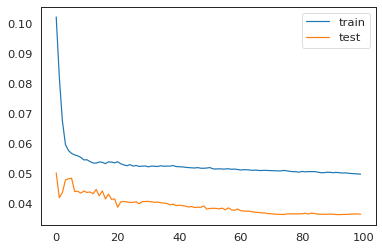

In [263]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing feature selected data

In [264]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(2191, 19)
Test MSE: 0.006
Test RMSE: 0.078
median_absolute_error 0.010221876
mean_absolute_error 0.036494914


## Conclusion for Combined Dataset after Gini

| data | MSE  |RMSE  |Median AE  |MAE|
|------|------|-----|------|-----|
|   without Gini  | 0.006| 0.081|0.010|0.038|
|   with Gini Coefficient(pos val)  | 0.006| 0.079|0.012|0.038|
|   with Gini ExtraTree Classifier(top6)  | 0.006| 0.077|0.010|0.036|




# 2.Load Maryland inertia for CA

In [265]:
CA_maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_processedMarylandData_Jan11.csv',low_memory=False)
CA_maryland_sd_inertia.head(5)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,0,1666753,-21.7000,2020-01-01,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,0,1666753,-5.8000,2020-01-02,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,0,1666753,-1.5000,2020-01-03,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,0,1666753,-2.2000,2020-01-04,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,0.3000,0.0000
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,0,1666753,-12.1000,2020-01-05,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,131,2.0500,0.2200,nan,0.0000,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,0.3000,0.0000


In [266]:
print(len(CA_maryland_sd_inertia.columns))
CA_maryland_sd_inertia.dtypes


47


countyFIPS                                  int64
County Name                                object
State                                      object
population                                  int64
CTFIPS                                      int64
CTNAME                                     object
STFIPS                                      int64
Social.distancing.index                     int64
X..staying.home                             int64
Trips.person                              float64
X..out.of.county.trips                    float64
X..out.of.state.trips                     float64
Miles.person                              float64
Work.trips.person                         float64
Non.work.trips.person                     float64
New.COVID.cases                             int64
Population                                  int64
X..change.in.consumption                  float64
date                                       object
Transit.mode.share                        float64


## Features

In [267]:
inertia_X_cols_all = ['Social.distancing.index', 'X..staying.home', 'Trips.person',
                  'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
                  'Work.trips.person', 'Non.work.trips.person','X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans','X..Hispanic.Americans',
        'X..Male', 'Population.density',
       'Employment.density', 
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home','population',	'CTFIPS',
       'Cumulative.inflation.rate', 'date','New.COVID.cases']



# from gini coeffs; only taking positive value features
#population?
inertia_X_cols_featured_gini_coef = ['Social.distancing.index', 'X..staying.home', 'Trips.person',
                  'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
                  'Work.trips.person', 'Non.work.trips.person','Transit.mode.share',
                  'X..people.older.than.60', 'Median.income', 'X..African.Americans','X..Hispanic.Americans',
                    'X..Male', 'Population.density',
                  'Employment.density', 'Hospital.beds.1000.people', 
                  'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
                  'X..hospital.bed.utilization', 'Testing.capacity',
                  'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
                  'Imported.COVID.cases', 'COVID.exposure.1000.people',
                  'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
                  'Unemployment.rate', 'X..working.from.home','population',	'CTFIPS',
                  'Cumulative.inflation.rate', 'date','New.COVID.cases']

# from gini extra tree classifier; taking top 20/
#population?
inertia_X_cols_featured_gini_rfe = ['Tests.done.1000.people', 'X..working.from.home','X..Hispanic.Americans',
                                    'Cumulative.inflation.rate','X.days..decreasing.ILI.cases',
                                    'X..people.older.than.60','COVID.exposure.1000.people','Median.income',
                                    'Unemployment.rate',
                                    'X.days..decreasing.COVID.cases','Population',
                                    'X..hospital.bed.utilization','Active.cases.1000.people',
                                    'Population.density','Ventilator.shortage','Imported.COVID.cases',
                                    'X..ICU.utilization','X..hot.spots.1000.people','COVID.death.rate',
                                    'Transit.mode.share','Testing.capacity','population',	'CTFIPS',
                                    'date','New.COVID.cases']


In [268]:
#for LA only code: old

LA_inertia_data_all = CA_maryland_sd_inertia[CA_maryland_sd_inertia['CTNAME'] == 'Los Angeles County'][inertia_X_cols_all]
LA_inertia_data_featured_gini_coef = CA_maryland_sd_inertia[CA_maryland_sd_inertia['CTNAME'] == 'Los Angeles County'][inertia_X_cols_featured_gini_coef]
LA_inertia_data_featured_gini_rfe = CA_maryland_sd_inertia[CA_maryland_sd_inertia['CTNAME'] == 'Los Angeles County'][inertia_X_cols_featured_gini_rfe]

print(len(LA_inertia_data_all.columns))
LA_inertia_data_all.head()

37


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,Hospital.beds.1000.people,ICUs.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,population,CTFIPS,Cumulative.inflation.rate,date,New.COVID.cases
6534,49,32,2.4200,12.1000,0.6000,31.4000,0.2100,2.2100,-20.1000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,10039107,6037,0.3000,2020-01-01,0
6535,22,21,3.1900,11.3000,0.5000,36.6000,0.5600,2.6200,-5.3000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,10039107,6037,0.3000,2020-01-02,0
6536,18,20,3.3200,11.2000,0.4000,37.9000,0.5600,2.7700,0.2000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,10039107,6037,0.3000,2020-01-03,0
6537,29,24,3.1000,11.6000,0.5000,36.0000,0.3000,2.7900,0.9000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,10039107,6037,0.3000,2020-01-04,0
6538,40,28,2.7500,11.3000,0.5000,33.1000,0.2500,2.5000,-9.6000,6.0400,18,64251,7.9000,48.5000,49.2800,2125,972,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,10039107,6037,0.3000,2020-01-05,0


In [269]:
#taking all the counties

LA_inertia_data_all = CA_maryland_sd_inertia[inertia_X_cols_all]
LA_inertia_data_featured_gini_coef = CA_maryland_sd_inertia[inertia_X_cols_featured_gini_coef]
LA_inertia_data_featured_gini_rfe = CA_maryland_sd_inertia[inertia_X_cols_featured_gini_rfe]

print(len(LA_inertia_data_all.columns))
LA_inertia_data_all.head()

37


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,Hospital.beds.1000.people,ICUs.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,population,CTFIPS,Cumulative.inflation.rate,date,New.COVID.cases
0,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,-21.7000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,2020-01-01,0
1,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,-5.8000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,2020-01-02,0
2,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,-1.5000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,2020-01-03,0
3,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,-2.2000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,2020-01-04,0
4,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,-12.1000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,1671329,6001,0.3000,2020-01-05,0


## Preprocess Data for All inertia datasets

In [270]:
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [271]:
print(len(inertia_X_cols_all))
LA_inertia_data_all['date'] = LA_inertia_data_all['date'].apply(lambda x:datetime_to_float(x))

37


### Date Column Index

In [272]:
col_idx = len(LA_inertia_data_all.columns) - 1
print(col_idx)

36


In [273]:
print(LA_inertia_data_all.shape)
LA_inertia_data_all.head()

(21054, 37)


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,Hospital.beds.1000.people,ICUs.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,population,CTFIPS,Cumulative.inflation.rate,date,New.COVID.cases
0,50,32,2.4100,26.1000,0.4000,38.0000,0.2000,2.2100,-21.7000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,1577836800.0000,0
1,24,22,3.1700,27.9000,0.4000,38.5000,0.5000,2.6600,-5.8000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,1577923200.0000,0
2,21,21,3.2800,27.2000,0.4000,41.0000,0.5100,2.7800,-1.5000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,1578009600.0000,0
3,34,25,3.0300,25.8000,0.3000,41.1000,0.2600,2.7600,-2.2000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.9000,3.9000,5.7000,1671329,6001,0.3000,1578096000.0000,0
4,44,29,2.7200,24.5000,0.4000,35.8000,0.2400,2.4800,-12.1000,15.0400,19,92574,10.5000,22.5000,49.1100,2002,1155,2.0500,0.2200,0.0000,0,54.0000,0.0000,0.0000,0.0000,0,0,0.0000,0,1.3000,3.9000,5.7000,1671329,6001,0.3000,1578182400.0000,0


In [274]:
values = LA_inertia_data_all.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var35(t)  var36(t)  var37(t)
1     0.5000     0.3200     0.0311  ...    0.0662    0.0028    0.0000
2     0.2400     0.2200     0.0409  ...    0.0662    0.0055    0.0000
3     0.2100     0.2100     0.0424  ...    0.0662    0.0083    0.0000
4     0.3400     0.2500     0.0391  ...    0.0662    0.0110    0.0000
5     0.4400     0.2900     0.0351  ...    0.0662    0.0138    0.0000

[5 rows x 74 columns]


### Train Test split

In [275]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

16840
values shape  (21053, 74)
(16840, 1, 73) (16840,) (4213, 1, 73) (4213,)


### Training LSTM for inertia data

In [276]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
234/234 - 3s - loss: 0.0710 - val_loss: 0.0358
Epoch 2/100
234/234 - 0s - loss: 0.0558 - val_loss: 0.0310
Epoch 3/100
234/234 - 0s - loss: 0.0465 - val_loss: 0.0244
Epoch 4/100
234/234 - 0s - loss: 0.0425 - val_loss: 0.0287
Epoch 5/100
234/234 - 0s - loss: 0.0422 - val_loss: 0.0268
Epoch 6/100
234/234 - 1s - loss: 0.0376 - val_loss: 0.0420
Epoch 7/100
234/234 - 0s - loss: 0.0377 - val_loss: 0.0410
Epoch 8/100
234/234 - 1s - loss: 0.0376 - val_loss: 0.0307
Epoch 9/100
234/234 - 0s - loss: 0.0365 - val_loss: 0.0246
Epoch 10/100
234/234 - 1s - loss: 0.0362 - val_loss: 0.0277
Epoch 11/100
234/234 - 0s - loss: 0.0347 - val_loss: 0.0261
Epoch 12/100
234/234 - 0s - loss: 0.0338 - val_loss: 0.0247
Epoch 13/100
234/234 - 0s - loss: 0.0330 - val_loss: 0.0243
Epoch 14/100
234/234 - 1s - loss: 0.0334 - val_loss: 0.0237
Epoch 15/100
234/234 - 0s - loss: 0.0318 - val_loss: 0.0271
Epoch 16/100
234/234 - 0s - loss: 0.0322 - val_loss: 0.0280
Epoch 17/100
234/234 - 0s - loss: 0.0316 - val_lo

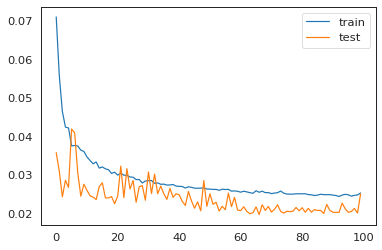

In [277]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing LSTM for inertia data

In [278]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import median_absolute_error, mean_absolute_error
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(4213, 73)
Test MSE: 0.003
Test RMSE: 0.058
median_absolute_error 0.006651791
mean_absolute_error 0.025175286


## Preprocessing Data for Gini-Coefficient Selected Features- Inertia

In [279]:
print(len(inertia_X_cols_featured_gini_coef))
LA_inertia_data_featured_gini_coef['date'] = LA_inertia_data_featured_gini_coef['date'].apply(lambda x:datetime_to_float(x))

35


### Date Column Index

In [280]:
col_idx = len(LA_inertia_data_featured_gini_coef.columns) - 1
print(col_idx)

34


In [281]:
values = LA_inertia_data_featured_gini_coef.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var33(t)  var34(t)  var35(t)
1     0.5000     0.3200     0.0311  ...    0.0662    0.0028    0.0000
2     0.2400     0.2200     0.0409  ...    0.0662    0.0055    0.0000
3     0.2100     0.2100     0.0424  ...    0.0662    0.0083    0.0000
4     0.3400     0.2500     0.0391  ...    0.0662    0.0110    0.0000
5     0.4400     0.2900     0.0351  ...    0.0662    0.0138    0.0000

[5 rows x 70 columns]


### Train Test Split

In [282]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

16840
values shape  (21053, 70)
(16840, 1, 69) (16840,) (4213, 1, 69) (4213,)


### Training LSTM for Gini Co-eff feature selected 

In [283]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
234/234 - 2s - loss: 0.0735 - val_loss: 0.0303
Epoch 2/100
234/234 - 1s - loss: 0.0564 - val_loss: 0.0287
Epoch 3/100
234/234 - 1s - loss: 0.0477 - val_loss: 0.0261
Epoch 4/100
234/234 - 1s - loss: 0.0415 - val_loss: 0.0259
Epoch 5/100
234/234 - 1s - loss: 0.0391 - val_loss: 0.0349
Epoch 6/100
234/234 - 1s - loss: 0.0359 - val_loss: 0.0245
Epoch 7/100
234/234 - 1s - loss: 0.0366 - val_loss: 0.0238
Epoch 8/100
234/234 - 1s - loss: 0.0365 - val_loss: 0.0247
Epoch 9/100
234/234 - 1s - loss: 0.0358 - val_loss: 0.0251
Epoch 10/100
234/234 - 0s - loss: 0.0346 - val_loss: 0.0243
Epoch 11/100
234/234 - 1s - loss: 0.0351 - val_loss: 0.0233
Epoch 12/100
234/234 - 1s - loss: 0.0334 - val_loss: 0.0239
Epoch 13/100
234/234 - 1s - loss: 0.0316 - val_loss: 0.0269
Epoch 14/100
234/234 - 1s - loss: 0.0318 - val_loss: 0.0225
Epoch 15/100
234/234 - 1s - loss: 0.0311 - val_loss: 0.0337
Epoch 16/100
234/234 - 0s - loss: 0.0313 - val_loss: 0.0217
Epoch 17/100
234/234 - 1s - loss: 0.0306 - val_lo

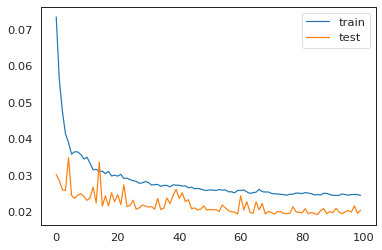

In [284]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing LSTM for Gini Co-eff feature selected

In [285]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(4213, 69)
Test MSE: 0.003
Test RMSE: 0.051
median_absolute_error 0.0034879716
mean_absolute_error 0.020515317


## Preprocessing Data for Gini-Extra Tree Classifier Selected Features- Inertia

In [286]:
print(len(inertia_X_cols_featured_gini_rfe))
LA_inertia_data_featured_gini_rfe['date'] = LA_inertia_data_featured_gini_rfe['date'].apply(lambda x:datetime_to_float(x))

25


### Date Column Index

In [287]:
col_idx = len(LA_inertia_data_featured_gini_rfe.columns) - 1
print(col_idx)

24


In [288]:
values = LA_inertia_data_featured_gini_rfe.values
# integer encode direction
encoder = LabelEncoder()
values[:,col_idx] = encoder.fit_transform(values[:,col_idx])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var23(t)  var24(t)  var25(t)
1     0.0000     0.0000     0.1997  ...    0.0000    0.0028    0.0000
2     0.0000     0.0000     0.1997  ...    0.0000    0.0055    0.0000
3     0.0000     0.0000     0.1997  ...    0.0000    0.0083    0.0000
4     0.0000     0.0000     0.1997  ...    0.0000    0.0110    0.0000
5     0.0000     0.0000     0.1997  ...    0.0000    0.0138    0.0000

[5 rows x 50 columns]


### Train Test Split

In [289]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

16840
values shape  (21053, 50)
(16840, 1, 49) (16840,) (4213, 1, 49) (4213,)


### Training LSTM for Gini Co-eff feature selected 

In [290]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/100
234/234 - 3s - loss: 0.0630 - val_loss: 0.0293
Epoch 2/100
234/234 - 1s - loss: 0.0522 - val_loss: 0.0271
Epoch 3/100
234/234 - 1s - loss: 0.0446 - val_loss: 0.0247
Epoch 4/100
234/234 - 1s - loss: 0.0390 - val_loss: 0.0313
Epoch 5/100
234/234 - 0s - loss: 0.0353 - val_loss: 0.0231
Epoch 6/100
234/234 - 1s - loss: 0.0351 - val_loss: 0.0296
Epoch 7/100
234/234 - 1s - loss: 0.0344 - val_loss: 0.0254
Epoch 8/100
234/234 - 1s - loss: 0.0362 - val_loss: 0.0261
Epoch 9/100
234/234 - 0s - loss: 0.0357 - val_loss: 0.0321
Epoch 10/100
234/234 - 1s - loss: 0.0326 - val_loss: 0.0295
Epoch 11/100
234/234 - 1s - loss: 0.0323 - val_loss: 0.0255
Epoch 12/100
234/234 - 1s - loss: 0.0342 - val_loss: 0.0268
Epoch 13/100
234/234 - 1s - loss: 0.0317 - val_loss: 0.0223
Epoch 14/100
234/234 - 0s - loss: 0.0320 - val_loss: 0.0233
Epoch 15/100
234/234 - 1s - loss: 0.0313 - val_loss: 0.0297
Epoch 16/100
234/234 - 1s - loss: 0.0309 - val_loss: 0.0294
Epoch 17/100
234/234 - 0s - loss: 0.0312 - val_lo

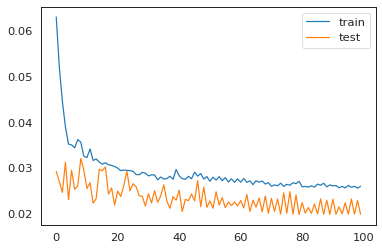

In [291]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing LSTM for Gini Co-eff feature selected

In [292]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(4213, 49)
Test MSE: 0.003
Test RMSE: 0.051
median_absolute_error 0.0029313262
mean_absolute_error 0.019927904


## Conclusion for Maryland Dataset after Gini

| data | MSE  |RMSE  |Median AE  |MAE|
|------|------|-----|------|-----|
|   without Gini  | 0.003| 0.050|0.004|0.220|
|   with Gini Coefficient(pos val)  | 0.003| 0.053|0.005|0.022|
|   with Gini ExtraTree Classifier(top6)  | 0.003| 0.052|0.006|0.022|

